In [34]:
!pip install moviepy

     ---------------------------------------- 0.0/388.3 kB ? eta -:--:--
     - -------------------------------------- 10.2/388.3 kB ? eta -:--:--
     -- ---------------------------------- 30.7/388.3 kB 435.7 kB/s eta 0:00:01
     --- --------------------------------- 41.0/388.3 kB 393.8 kB/s eta 0:00:01
     ----- ------------------------------- 61.4/388.3 kB 409.6 kB/s eta 0:00:01
     ----- ------------------------------- 61.4/388.3 kB 409.6 kB/s eta 0:00:01
     ------- ----------------------------- 81.9/388.3 kB 353.1 kB/s eta 0:00:01
     ------- ----------------------------- 81.9/388.3 kB 353.1 kB/s eta 0:00:01
     ------- ----------------------------- 81.9/388.3 kB 353.1 kB/s eta 0:00:01
     ------- ----------------------------- 81.9/388.3 kB 353.1 kB/s eta 0:00:01
     ------- ----------------------------- 81.9/388.3 kB 353.1 kB/s eta 0:00:01
     ------- ----------------------------- 81.9/388.3 kB 353.1 kB/s eta 0:00:01
     ------- ----------------------------- 81.9/388.3

  Using cached moviepy-1.0.3.tar.gz (388 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Obtaining dependency information for decorator<5.0,>=4.0.2 from https://files.pythonhosted.org/packages/ed/1b/72a1821152d07cf1d8b6fce298aeb06a7eb90f4d6d41acec9861e7cc6df0/decorator-4.4.2-py2.py3-none-any.whl.metadata
  Using cached decorator-4.4.2-py2.py3-none-any.whl.metadata (4.2 kB)
  Obtaining dependency information for proglog<=1.0.0 from https://files.pythonhosted.org/packages/8b/f5/cab5cf6a540c31f5099043de0ae43990fd9cf66f75ecb5e9f254a4e4d4ee/proglog-0.1.10-py3-none-any.whl.metadata
  Using cached proglog-0.1.10-py3-none-any.whl.metadata (639 bytes)
  Obtaining dependency information for imageio_ffmpeg>=0.2.0 from https://files.pythonhosted.org/packages/c6/01/716106099e48c4f419876d5814679a94dd7d6f441217c97c1b608123c6bb/imageio_ffmpeg-0.4.9-py3-none-win_amd64.whl.metadata
  Using cached imageio_ffmpeg-0.4.9-py3-none-win_amd64.whl.meta

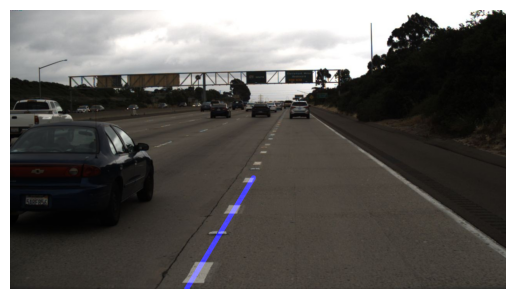

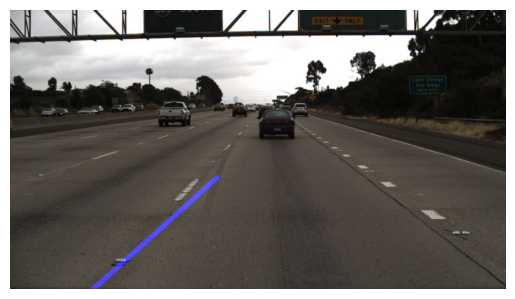

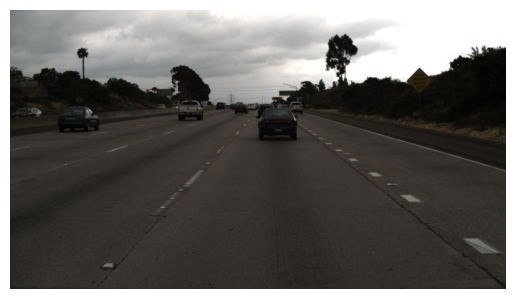

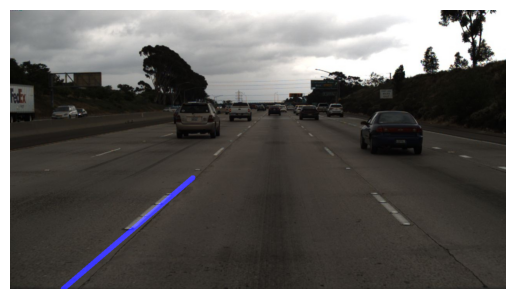

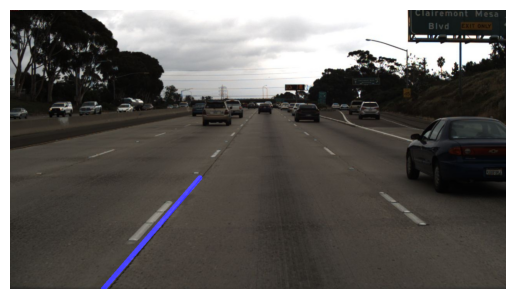

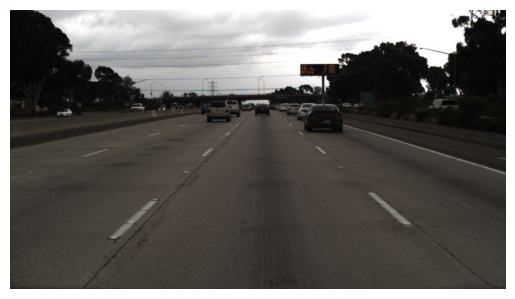

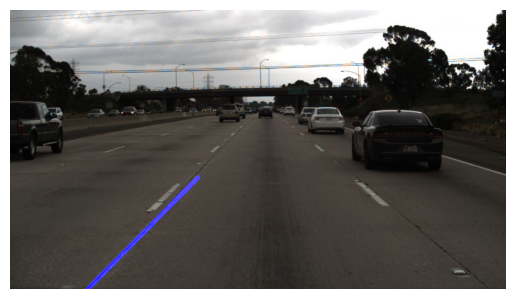

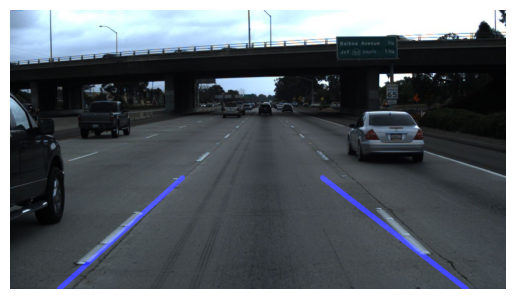

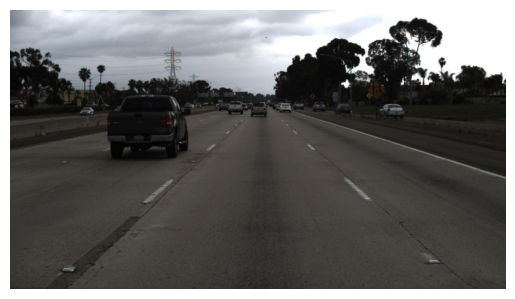

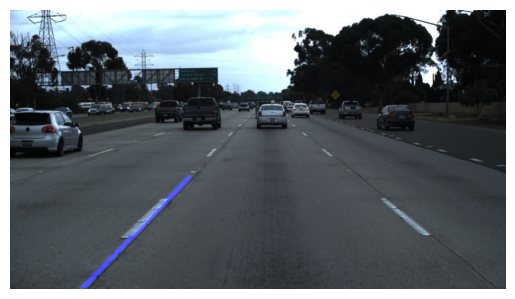

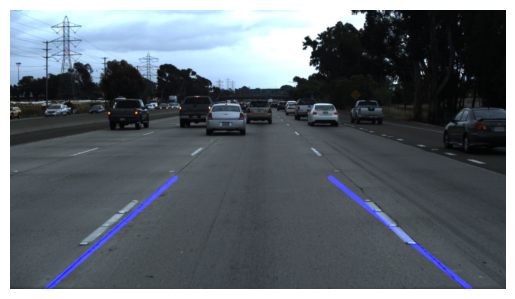

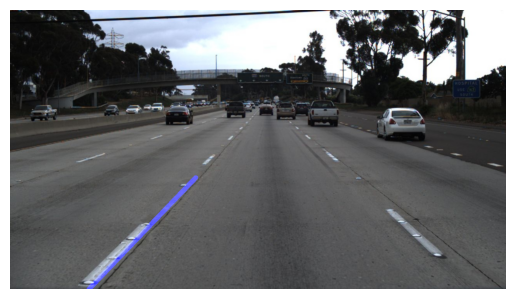

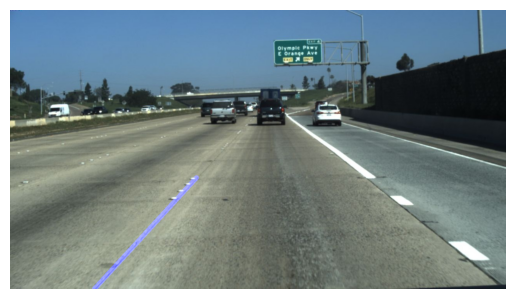

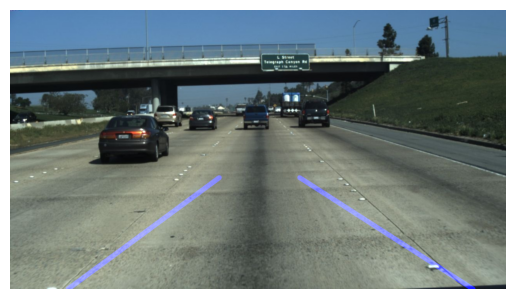

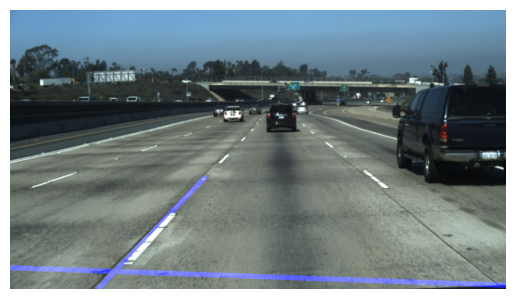

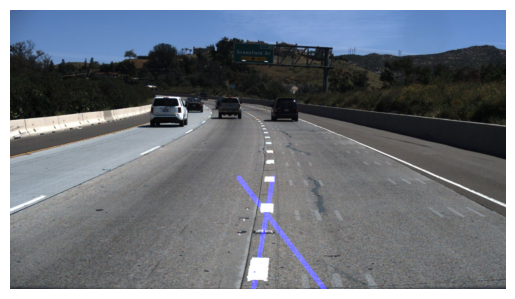

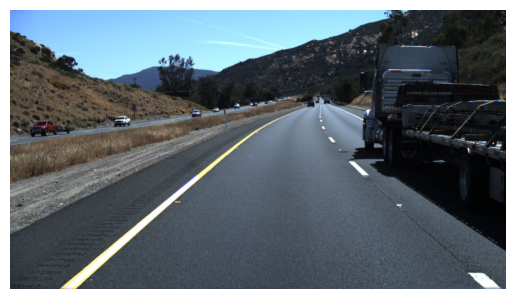

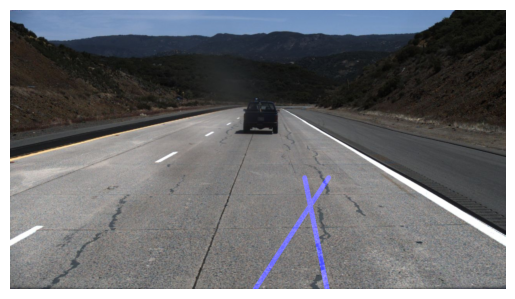

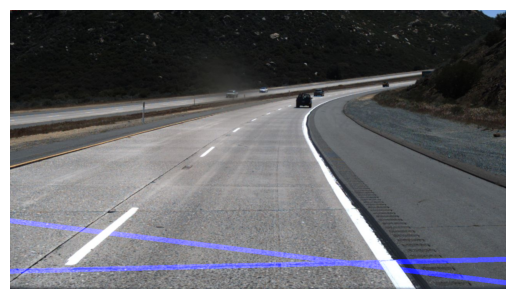

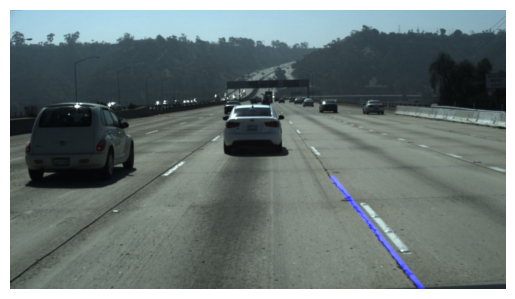

In [31]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def region_selection(image):
    mask = np.zeros_like(image)
    if len(image.shape) > 2:
        ignore_mask_color = (255,) * image.shape[2]
    else:
        ignore_mask_color = 255

    rows, cols = image.shape[:2]
    bottom_left = (int(cols * 0.1), int(rows * 0.95))
    top_left = (int(cols * 0.4), int(rows * 0.6))
    bottom_right = (int(cols * 0.9), int(rows * 0.95))
    top_right = (int(cols * 0.6), int(rows * 0.6))

    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image

def hough_transform(image):
    rho = 1
    theta = np.pi / 180
    threshold = 20
    min_line_length = 20
    max_line_gap = 500
    return cv2.HoughLinesP(image, rho=rho, theta=theta, threshold=threshold,
                           minLineLength=min_line_length, maxLineGap=max_line_gap)

def average_slope_intercept(lines):
    if lines is None:
        return None, None

    left_lines = []
    left_weights = []
    right_lines = []
    right_weights = []

    for line in lines:
        for x1, y1, x2, y2 in line:
            if x1 == x2:
                continue
            slope = (y2 - y1) / (x2 - x1)
            intercept = y1 - (slope * x1)
            length = np.sqrt(((y2 - y1) ** 2) + ((x2 - x1) ** 2))

            if slope < 0:
                left_lines.append((slope, intercept))
                left_weights.append(length)
            else:
                right_lines.append((slope, intercept))
                right_weights.append(length)

    left_lane = np.average(left_lines, weights=left_weights, axis=0) if left_weights else None
    right_lane = np.average(right_lines, weights=right_weights, axis=0) if right_weights else None
    return left_lane, right_lane

def pixel_points(y1, y2, line):
    if line is None:
        return None

    slope, intercept = line
    if slope == 0 or np.isinf(slope) or np.isinf(intercept):
        return None

    x1 = int((y1 - intercept) / slope)
    x2 = int((y2 - intercept) / slope)
    y1 = int(y1)
    y2 = int(y2)
    return ((x1, y1), (x2, y2))

def lane_lines(image, lines):
    left_lane, right_lane = average_slope_intercept(lines)
    y1 = image.shape[0]
    y2 = int(y1 * 0.6)
    left_line = pixel_points(y1, y2, left_lane)
    right_line = pixel_points(y1, y2, right_lane)
    return left_line, right_line

def draw_lane_lines(image, lines, color=(255, 0, 0), thickness=12):
    line_image = np.zeros_like(image)
    for line in lines:
        if line is not None:
            cv2.line(line_image, *line, color, thickness)
    return cv2.addWeighted(image, 1.0, line_image, 1.0, 0.0)

def frame_processor(image_path):
    image = cv2.imread(image_path)
    grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(grayscale, (5, 5), 0)
    edges = cv2.Canny(blur, 50, 150)
    region = region_selection(edges)
    hough = hough_transform(region)
    result = draw_lane_lines(image, lane_lines(image, hough))
    return result
for i in range(1,21):
# Load and process the image
  s=''
  s=s+str(i)
  s=s+'.jpg'
  image_path = s  # Update with your image path
  result = frame_processor(image_path)
  plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
  plt.axis('off')
  plt.show()

In [57]:
def process_frame(frame):
    grayscale = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(grayscale, (5, 5), 0)
    edges = cv2.Canny(blur, 50, 150)
    region = region_selection(edges)
    hough = hough_transform(region)
    result = draw_lane_lines(frame, lane_lines(frame, hough))
    return result

def process_video(video_path):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error opening video file")
        return

    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    out = cv2.VideoWriter("output.mp4", fourcc, fps, (frame_width, frame_height))

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        processed_frame = process_frame(frame)
        out.write(processed_frame)

        cv2.imshow("Processed Frame", processed_frame)
        if cv2.waitKey(1) & 0xFF == ord("q"):
            break

    cap.release()
    out.release()
    cv2.destroyAllWindows()
    print("output.mp4 is created.")

# Process a video file
video_path = "input.mp4"  # Update with your video path
process_video(video_path)

output.mp4 is created.
